# Classification d'image : Cassava Leaf Disease Classification
<center><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/13277/logos/header.png?t=2019-03-08-20-57-32"></center>

ESGI 4IADB1 groupe 7 : Cai Eddy - Taranto Tom - Sheikh Rakib - Mbae Hakim

Ce notebook développe différents modèles pour classer les images du dataset Cassava Leaf Disease Classification.

https://www.kaggle.com/c/cassava-leaf-disease-classification

# Import

In [1]:
# Tensorflow et keras
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, MaxPool2D, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow as tf

In [2]:
# Helper libraries
from PIL import Image
import datetime
import os
import json
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import seaborn as sn
import shutil
import glob
import cv2
import re
from random import random
from pathlib import Path

In [3]:
# Pour le GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
print('TensorFlow', tf.__version__)

TensorFlow 2.2.0


## Importation du dataset

In [5]:
# Ratio split des images (validation ratio % en validation)
validation_ratio = 0.2

In [6]:
general_path = '.'
dataset_train_folder = f"{general_path}/train"
dataset_val_folder = f"{general_path}/val"
destination_classes = [str(i) for i in range(5)]
original_train_data_folder = "./train_images"
csv_file = "./train.csv"

In [7]:
def compute_class_images_count(base_folder: str, class_name: str):
    return sum((1 for _ in os.listdir(f'{base_folder}/{class_name}')))

def compute_all_classes_images_count(base_folder: str):
    return sum((compute_class_images_count(base_folder, c) for c in destination_classes))

def compute_train_images_count():
    return compute_all_classes_images_count(dataset_train_folder)

def compute_val_images_count():
    return compute_all_classes_images_count(dataset_val_folder)

In [8]:
def clean_dataset():
    for c in destination_classes:
        folder = f'{dataset_train_folder}/{c}'
        for filename in os.listdir(folder):
            os.remove(f'{folder}/{filename}')

        folder = f'{dataset_val_folder}/{c}'
        for filename in os.listdir(folder):
            os.remove(f'{folder}/{filename}')


def clean_and_create_dataset():
    clean_dataset()
    filename_to_class_folder = {}
    with open(csv_file) as fo:
        for row in csv.reader(fo):
            filename_to_class_folder[row[0]] = row[1]

    for filename in os.listdir(original_train_data_folder):
        destination_folder = dataset_train_folder
        if random() < validation_ratio:
            destination_folder = dataset_val_folder

        shutil.copyfile(
            f'{original_train_data_folder}/{filename}',
            f'{destination_folder}/{filename_to_class_folder[filename]}/{filename}')

def clear_cache() :
    for p in Path("./train/").glob("cache*"):
        p.unlink()
    for p in Path("./val/").glob("cache*"):
        p.unlink()

In [9]:
#clean_and_create_dataset()

In [10]:
with open(os.path.join(general_path, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
data = pd.read_csv('train.csv')
data["name"] = data["label"].map(map_classes)
data['label'] = data['label'].astype('string')

## Exploration des données

Explorons le format de l'ensemble des données avant d'entraîner les modèles. Les données montrent qu'il y a 21 397 images dans l'ensemble du dataset encodé en RGB

In [11]:
data.shape

(21397, 3)

Il y a 17102 étiquettes dans les données d'apprentissage.

In [12]:
compute_train_images_count()

17102

Il y a 4295 étiquettes dans les données de validation.

In [13]:
compute_val_images_count()

4295

Chaque étiquette est un entier compris entre 0 et 4:

In [14]:
map_classes

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

Chaque image est représentée par 600 x 800 pixels:

In [15]:
array = np.array(Image.open('train_images/' + data.iloc[0]['image_id']))
print('Picture size', array.shape)

Picture size (600, 800, 3)


Affichons quelques images:

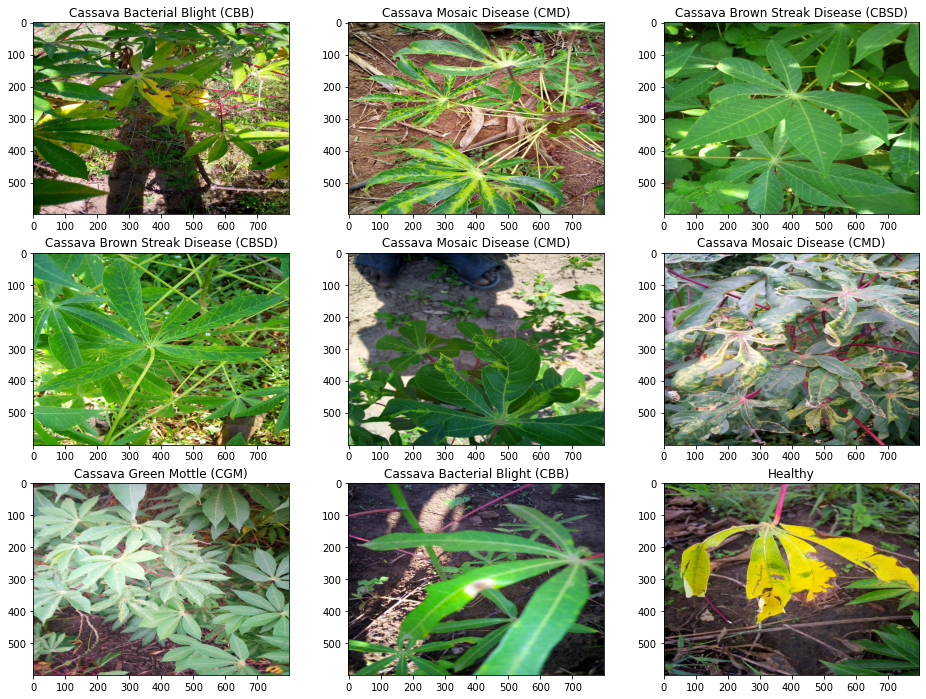

In [16]:
plt.figure(figsize=(16, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = Image.open('train_images/' + data.iloc[i]['image_id'])
    array = np.array(image)
    plt.imshow(array)
    label=data.iloc[i]['label']
    plt.title(f'{map_classes[int(label)]}')
plt.show()

Voici la répartition des classes du dataset complet.

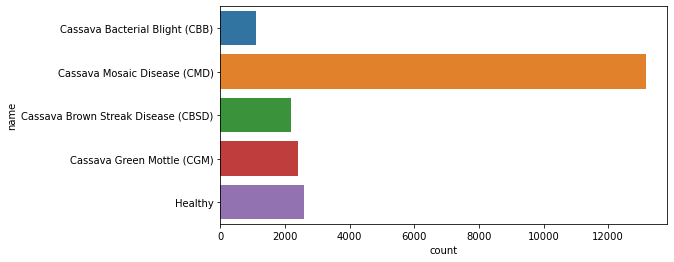

In [17]:
plt.figure(figsize=(8, 4))
sn.countplot(y="name", data=data);

## Ajustement poids des classes
<center><img src="https://i.imgflip.com/2j058p.jpg"></center>

In [18]:
# compter les images
var0 = compute_class_images_count("./train", 0)
var1 = compute_class_images_count("./train", 1)
var2 = compute_class_images_count("./train", 2)
var3 = compute_class_images_count("./train", 3)
var4 = compute_class_images_count("./train", 4)
# total
toto = compute_train_images_count()
# normalise
var0 = var0/toto
var1 = var1/toto
var2 = var2/toto
var3 = var3/toto
var4 = var4/toto
# minimum
m = np.min(np.array([var0,var1,var2,var3,var4]))

In [19]:
class_weight = {0: (1 - var0) / (1 - m),
                1: (1 - var1) / (1 - m),
                2: (1 - var2) / (1 - m),
                3: (1 - var3) / (1 - m),
                4: (1 - var4) / (1 - m)}

class_weight

{0: 1.0,
 1: 0.9405910180008601,
 2: 0.934447379738281,
 3: 0.40203968790317623,
 4: 0.925661977022793}

# Perceptron Multicouches

## Prétraitement des données

On normalise entre 0 et 1 avant de les transmettre aux différents modèles. Pour ce faire, on divise les valeurs par 255. Il est important que l'ensemble des données d'apprentissage et l'ensemble des données de test soient prétraitées de la même manière:

### Entrainement

In [20]:
def create_dataset_iterator_train(base_folder: str, size: int):
    def inner_func():
        return ImageDataGenerator(rescale=1.0 / 255, rotation_range = 60, width_shift_range = 0.3, height_shift_range = 0.3,
                                  shear_range = 0.3, zoom_range = 0.3, vertical_flip=True, horizontal_flip=True
                                 ).flow_from_directory(base_folder, target_size=target_size, batch_size=1)

    return (tf.data.Dataset.from_generator(inner_func, output_types=(tf.float32, tf.float32), 
                                           output_shapes=((1, *target_size, 3), (1, len(destination_classes))))
            .take(size)
            .unbatch()
            .batch(batch_size)
            .cache(f'{base_folder}/cache')
            .repeat()
            .prefetch(2)
            .as_numpy_iterator())

### Validation

In [21]:
def create_dataset_iterator_validation(base_folder: str, size: int):
    def inner_func():
        return ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(base_folder, target_size=target_size, batch_size=1)

    return (tf.data.Dataset.from_generator(inner_func, output_types=(tf.float32, tf.float32), 
                                           output_shapes=((1, *target_size, 3),(1, len(destination_classes))))
            .take(size)
            .unbatch()
            .batch(batch_size)
            .cache(f'{base_folder}/cache')
            .repeat()
            .prefetch(2)
            .as_numpy_iterator())

## Construire les modèles

La construction des modèles nécessite la configuration des couches des modèles, puis la compilation des modèles.

In [22]:
def pmc_2_1000():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(1000, activation="relu"))
    model.add(Dense(1000, activation="relu"))
    model.add(Dense(units=5, activation="softmax"))
    return model

In [23]:
def pmc_2_1000_normalization():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(1000, activation="linear"))
    model.add(BatchNormalization())
    model.add(Activation(activation="relu"))
    model.add(Dense(1000, activation="linear"))
    model.add(BatchNormalization())
    model.add(Activation(activation="relu"))
    model.add(Dense(units=5, activation="softmax"))
    return model

In [24]:
def pmc_4_577():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(577, activation="relu"))
    model.add(Dense(577, activation="relu"))
    model.add(Dense(577, activation="relu"))
    model.add(Dense(577, activation="relu"))
    model.add(Dense(units=5, activation="softmax"))
    return model

In [25]:
def pmc_4_577_normalization():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(577, activation="linear"))
    model.add(BatchNormalization())
    model.add(Activation(activation="relu"))
    model.add(Dense(577, activation="linear"))
    model.add(BatchNormalization())
    model.add(Activation(activation="relu"))
    model.add(Dense(577, activation="linear"))
    model.add(BatchNormalization())
    model.add(Activation(activation="relu"))
    model.add(Dense(577, activation="linear"))
    model.add(BatchNormalization())
    model.add(Activation(activation="relu"))
    model.add(Flatten())
    model.add(Dense(units=5, activation="softmax"))
    return model

## Fonction d'entrainement

In [26]:
def Model_fit(model, dir_log):
    model = model()
    
    #COMPILE MODEL
    model.compile(
        optimizer = OPTIMIZER,
        loss = LOSS,
        metrics = METRICS
    )
    
    CHECKPOINT = ModelCheckpoint(str(dir_log)+".h5", monitor='val_loss', mode='min', save_best_only=True)
    
    # Tensorboard supervision
    log_dir = "logs/fit/" + str(dir_log)+"_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # FITTING
    history = model.fit(
        create_dataset_iterator_train(dataset_train_folder, train_size),
        validation_data = create_dataset_iterator_validation(dataset_val_folder, val_size),
        epochs= EPOCHS,
        batch_size = BATCH_SIZE,
        class_weight = class_weight,
        steps_per_epoch = train_size // batch_size,
        validation_steps = val_size // batch_size,
        callbacks = [
            ES,
            CHECKPOINT, 
            reduce_lr],
#            tensorboard_callback],
        verbose = 1)
    
    model.save(str(dir_log)+'_final.h5')  
    
    return history

In [27]:
# Variable Compile
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"
METRICS = ["categorical_accuracy"]

# Calls Back
ES = EarlyStopping(monitor='val_loss', patience=8, mode='min', restore_best_weights=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 4, min_lr = 1e-6, mode = 'min', verbose = 1)

# Variable prétraitement
batch_size = 64
target_size = (256, 256)

# Variable d'entrainement
seed = 0
np.random.seed = seed
tf.random.set_seed(seed)
NB_CLASS = 5
BATCH_SIZE = 64
EPOCHS = 100
NB_EXPERIENCE = 5

# Modèles
var_models = [pmc_2_1000, pmc_2_1000_normalization, pmc_4_577, pmc_4_577_normalization]
names = ["pmc_2_1000", "pmc_2_1000_normalization", "pmc_4_577", "pmc_4_577_normalization"]

## Entrainement

In [ ]:
for index_models in range(len(var_models)): # on parcourt tous les modèles
    for current_experience in range(NB_EXPERIENCE): # on entraine notre modèle plusieur fois (nb_experience fois)
        
        seed += 1 # set de seed
        tf.random.set_seed(seed) # set de seed
        np.random.seed = seed # set de seed
        
        # nom du model + current experience
        dir_log = str(names[index_models])+"_"+str(current_experience)
        
        # entrainement du modèle
        history = Model_fit(var_models[index_models], dir_log)

        # Sauvegarde du fit pour les plots
        hist_df = pd.DataFrame(history.history)
        hist_csv_file = 'history_'+dir_log+'.csv'
        
        with open(hist_csv_file, mode='w') as f:
            hist_df.to_csv(f)

## Nos Runs (plot)

In [28]:
def plot_name2(all_logs, exp, name="loss", ax = None):
    for k in range(len(all_logs)):
        length = max(len(all_logs[k][i][name]) for i in range(len(all_logs[k])))
        res = [[] for _ in range(len(all_logs[k]))]
        for i in range(len(all_logs[k])):
            if len(all_logs[k][i][name]) < length: 
                res[i] = np.append(all_logs[k][i][name], np.repeat(np.nan, length - len(all_logs[k][i][name])))
            else :
                res[i] = all_logs[k][i][name]

        mean = np.nanmean(res, axis = 0)
        std = np.nanstd(res, axis = 0)  
        if ax is None:
            ax = plt.gca()
        ax.plot(list(range(0,length)), mean, label = exp[k])
        ax.fill_between(list(range(length)), np.array(mean) - np.array(std), np.array(mean) + np.array(std), alpha = 0.2 )
    ax.set_title("mean " + name)
    ax.set_xlabel("epoch")
    return ax

def plot_logs2(all_logs, exp):
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey='row', figsize=(10,10))
    p1 = plot_name2(all_logs, name = 'loss' , exp = exp, ax = ax1)
    p2 = plot_name2(all_logs, name = 'val_loss' , exp = exp, ax = ax2)
    p3 = plot_name2(all_logs, name = "categorical_accuracy" , exp = exp, ax = ax3)
    p4 = plot_name2(all_logs, name = 'val_categorical_accuracy' , exp = exp, ax = ax4)
    p2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    p4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [29]:
def load_csv(path):
    #Creation de la liste des csv : 
    list_csv_files = glob.glob(path+'/*.csv')

    #On load les fichiers en table
    list_globale = []
    list_globale.append([])
    for i in range(len(list_csv_files)):
        list_globale[0].append(pd.read_csv(list_csv_files[i]))

    return list_globale

In [30]:
def load_csv2(path, path2):
    #Creation de la liste des csv : 
    list_csv_files = glob.glob(path+'/*.csv')
    list_csv_files2 = glob.glob(path2+'/*.csv')

    #On load les fichiers en table
    list_globale = []
    list_globale.append([])
    list_globale.append([])
    for i in range(len(list_csv_files)):
        list_globale[0].append(pd.read_csv(list_csv_files[i]))
        
    for i in range(len(list_csv_files2)):
        list_globale[1].append(pd.read_csv(list_csv_files2[i]))

    return list_globale

In [31]:
def load_csv3(path, path2, path3):
    #Creation de la liste des csv : 
    list_csv_files = glob.glob(path+'/*.csv')
    list_csv_files2 = glob.glob(path2+'/*.csv')
    list_csv_files3 = glob.glob(path3+'/*.csv')

    #On load les fichiers en table
    list_globale = []
    list_globale.append([])
    list_globale.append([])
    list_globale.append([])
    for i in range(len(list_csv_files)):
        list_globale[0].append(pd.read_csv(list_csv_files[i]))
        
    for i in range(len(list_csv_files2)):
        list_globale[1].append(pd.read_csv(list_csv_files2[i]))
        
    for i in range(len(list_csv_files3)):
        list_globale[2].append(pd.read_csv(list_csv_files3[i]))

    return list_globale

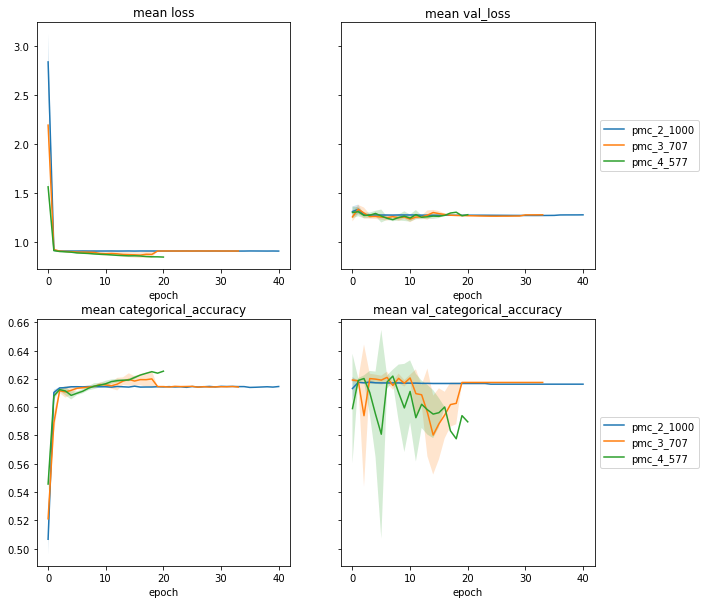

In [32]:
names = ['pmc_2_1000', 'pmc_3_707', 'pmc_4_577']
plot_pmc_2 = load_csv3("h5_finaux/pmc_2_1000", "h5_finaux/pmc_3_707", "h5_finaux/pmc_4_577")
plot_logs2(plot_pmc_2,names)

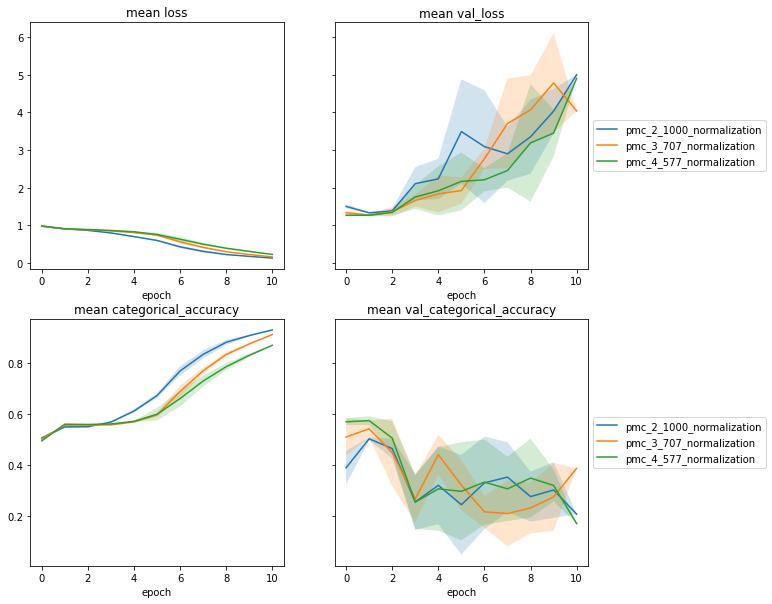

In [33]:
names = ['pmc_2_1000_normalization', 'pmc_3_707_normalization', 'pmc_4_577_normalization']
plot_pmc_2 = load_csv3("h5_finaux/pmc_2_1000_normalization", "h5_finaux/pmc_3_707_normalization", "h5_finaux/pmc_4_577_normalization")
plot_logs2(plot_pmc_2,names)

# ResNet

## Prétraitement des données

In [34]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(data, test_size = 0.1, random_state = 42, stratify = data['label'])

In [35]:
IMG_SIZE = 256

### Entrainement

In [36]:
datagen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

train = datagen_train.flow_from_dataframe(
    dataframe=train_set,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    class_mode = 'categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    subset='training',
    shuffle=True,
    seed=12345
)

Found 0 validated image filenames belonging to 0 classes.


C:\Users\Eddy_\miniconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 19257 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


### Validation

In [37]:
datagen_valid = ImageDataGenerator(
    rescale = 1./255
)

valid = datagen_valid.flow_from_dataframe(
    dataframe=valid_set,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    class_mode = 'categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    subset='training',
    shuffle=True,
    seed=12345
)

Found 0 validated image filenames belonging to 0 classes.


C:\Users\Eddy_\miniconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2140 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Construire les modèles

In [38]:
def resnet():
    model = ResNet50(classes = 5, inputs= Input(shape=(IMG_SIZE,IMG_SIZE,3)))
    return model

## Fonction d'entrainement

In [39]:
# Modèles
var_models = [resnet]
names = ["resnet"]

## Nos Runs

![](resnet.png)

# U-net

## Prétraitement des données

In [40]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [41]:
from functools import partial
# Source : https://keras.io/examples/keras_recipes/tfrecord/


def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [*IMAGE_SIZE])
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [42]:
GCS_PATH = './'
TEST_SIZE=0.10
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/*.tfrec'),
    test_size=TEST_SIZE, random_state=5
)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')


In [43]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0.6, 1.6)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = tf.image.random_jpeg_quality(image, 10, 100)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image, label

In [44]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [45]:
NUM_TRAINING_IMAGES = len(TRAINING_FILENAMES) * 1024
NUM_VALIDATION_IMAGES = len(VALID_FILENAMES) * 1024
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

In [46]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# load our training dataset for EDA
#training_dataset = get_training_dataset()
#training_dataset = training_dataset.unbatch().batch(20)
#training_dataset = training_dataset.cache("/kaggle/temp/train_cache")
#train_batch = iter(training_dataset)
# load our validation dataset for EDA
#validation_dataset = get_validation_dataset()
#validation_dataset = validation_dataset.unbatch().batch(20)
#valid_batch = iter(validation_dataset)

#testing_dataset = get_test_dataset()
#testing_dataset = testing_dataset.unbatch().batch(20)
#test_batch = iter(testing_dataset)

## Construire les modèles


In [47]:
from tensorflow.keras import layers

def Unet(img_size=(488,488)):
    inputs = keras.Input(shape=img_size + (3,))
    print("input ok")
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    print("entry block ok")
    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    x = layers.Conv2D(5, 3, activation="softmax", padding="valid")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(units= 5, activation='softmax')(x)
    # Define the model
    model = keras.Model(inputs, outputs)
    
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

## Fonction d'entrainement

In [48]:
def Model_fit(model, dir_log):
    with strategy.scope():      
        model = model()
    
        #COMPILE MODEL
        model.compile(
            optimizer = OPTIMIZER,
            loss = LOSS,
            metrics = METRICS
        )
    
        CHECKPOINT = ModelCheckpoint(str(dir_log)+".h5", monitor='val_loss', mode='min', save_best_only=True)
        # Tensorboard supervision
        log_dir = "logs/fit/" + str(dir_log)+"_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
        # FITTING
        history = model.fit(
            train_dataset,
            validation_data = valid_dataset,
            epochs= EPOCHS,
            batch_size = BATCH_SIZE,
            #class_weight = class_weight,
            steps_per_epoch = STEPS_PER_EPOCH,
            validation_steps = VALID_STEPS,
            callbacks = [
                ES,
                CHECKPOINT, 
                reduce_lr],
                #tensorboard_callback],
            verbose = 1)
        
        return history

In [49]:
# Variable Compile
LOSS = "sparse_categorical_crossentropy"
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=1e-4)
METRICS = ["sparse_categorical_accuracy"]

#train_dataset = get_training_dataset()
#valid_dataset = get_validation_dataset()

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
HEIGHT = IMAGE_SIZE[0]
WIDTH = IMAGE_SIZE[1]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 100

#modèle
var_models = [Unet]
names = ["Unet"]

## Nos Runs (plot)

![](unit.png)

# ConvPaper

## Prétraitement des données

In [50]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0.6, 1.6)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = tf.image.random_jpeg_quality(image, 10, 100)
    image = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)), lambda: image)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image, label

## Construire les modèles

In [51]:
def convPaper2_dp():
    model = Sequential()
    # First Conv couche
    model.add(Conv2D(32, (5, 5), activation="relu", input_shape=(*IMAGE_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    # Second conv 
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    # Third conv
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    # Fully connected
    model.add(Flatten())
    model.add(Dense(units=512, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.02))
    model.add(Dense(units=1024, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.02))
    model.add(Dense(units=1024, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.02))
    model.add(Dense(units=256, activation="relu"))
    model.add(Dropout(0.02))
    model.add(Dense(units=5, activation="softmax"))
    return model

In [52]:
def convPaper2_dp3():
    model = Sequential()
    # First Conv couche
    model.add(Conv2D(32, (5, 5), activation="relu", input_shape=(*IMAGE_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    # Second conv 
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    # Third conv
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3,3))
    # Fully connected
    model.add(Flatten())
    model.add(Dense(units=512, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.3))
    model.add(Dense(units=1024, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.3))
    model.add(Dense(units=1024, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.3))
    model.add(Dense(units=256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(units=5, activation="softmax"))
    return model

## Fonction d'entrainement

In [53]:
#OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=1e-4)

#opt = CyclicalLearningRate(1e-3, 1e-7, STEP_SIZE, lambda x: 1 / (2.0 ** (x - 1)))
#OPTIMIZER  = Adam(learning_rate=opt)

#from tensorflow_addons.optimizers import CyclicalLearningRate, AdamW
def scale_fn(x):
    return 1. ** x

#opt = CyclicalLearningRate(1e-3, 1e-7, step_size = STEP_SIZE, scale_fn=scale_fn)
#OPTIMIZER  = AdamW(weight_decay = 1e-6, learning_rate=opt)


#epochs_within_each_step = 2
#STEP_SIZE = STEPS_PER_EPOCH * epochs_within_each_step

#epochs_within_each_step = 4
#STEP_SIZE = STEPS_PER_EPOCH * epochs_within_each_step

## Nos Runs (plot)

In [54]:
def plot_name2(all_logs, exp, name="loss", ax = None):
    for k in range(len(all_logs)):
        length = max(len(all_logs[k][i][name]) for i in range(len(all_logs[k])))
        res = [[] for _ in range(len(all_logs[k]))]
        for i in range(len(all_logs[k])):
            if len(all_logs[k][i][name]) < length: 
                res[i] = np.append(all_logs[k][i][name], np.repeat(np.nan, length - len(all_logs[k][i][name])))
            else :
                res[i] = all_logs[k][i][name]

        mean = np.nanmean(res, axis = 0)
        std = np.nanstd(res, axis = 0)  
        if ax is None:
            ax = plt.gca()
        ax.plot(list(range(0,length)), mean, label = exp[k])
        ax.fill_between(list(range(length)), np.array(mean) - np.array(std), np.array(mean) + np.array(std), alpha = 0.2 )
    ax.set_title("mean " + name)
    ax.set_xlabel("epoch")
    return ax

def plot_logs2(all_logs, exp):
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey='row', figsize=(10,10))
    p1 = plot_name2(all_logs, name = 'loss' , exp = exp, ax = ax1)
    p2 = plot_name2(all_logs, name = 'val_loss' , exp = exp, ax = ax2)
    p3 = plot_name2(all_logs, name = "sparse_categorical_accuracy" , exp = exp, ax = ax3)
    p4 = plot_name2(all_logs, name = 'val_sparse_categorical_accuracy' , exp = exp, ax = ax4)
    p2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    p4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

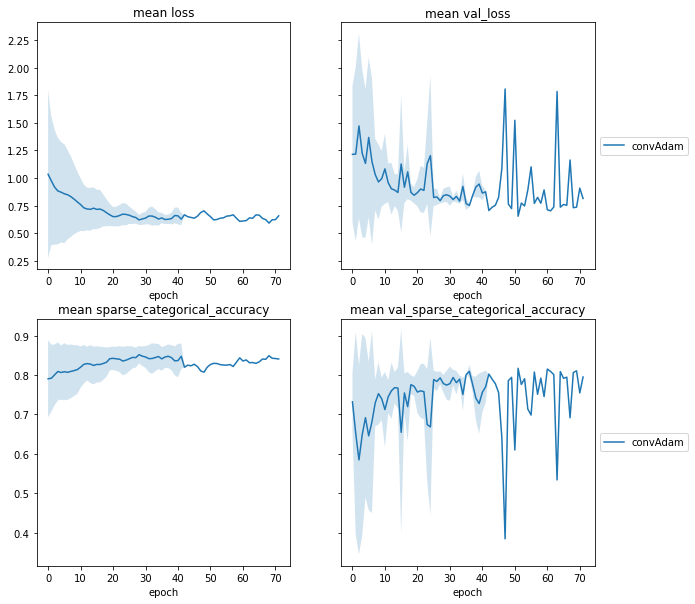

In [55]:
names = ['convAdam']
plot_pmc_2 = load_csv("h5_finaux/conv79_5")
plot_logs2(plot_pmc_2,names)

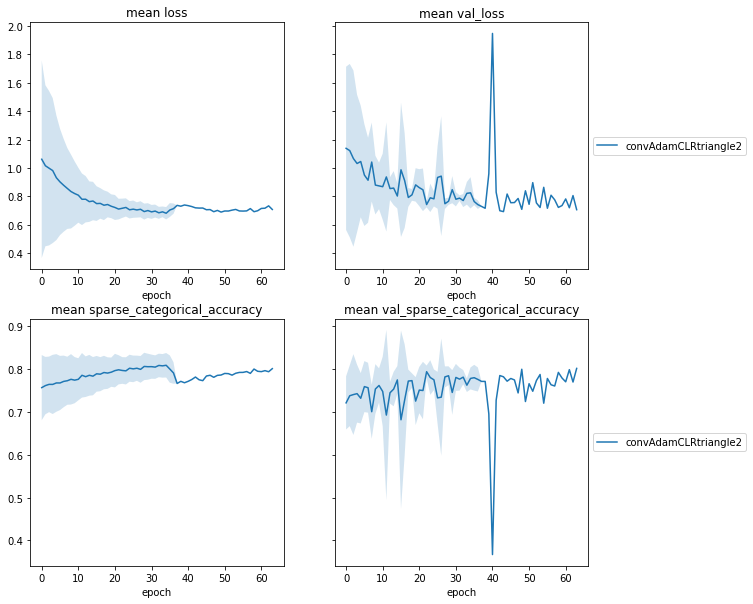

In [56]:
names = ['convAdamCLRtriangle2']
plot_pmc_2 = load_csv("h5_finaux/conv80_4")
plot_logs2(plot_pmc_2,names)

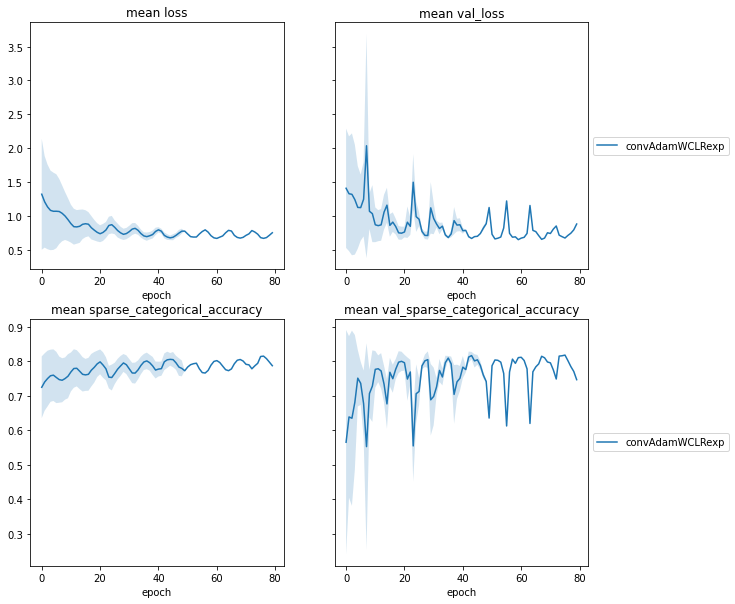

In [57]:
names = ['convAdamWCLRexp']
plot_pmc_2 = load_csv("h5_finaux/conv81_9")
plot_logs2(plot_pmc_2,names)

# EfficientNet

## Construire les modèles

In [58]:
#from tensorflow.keras.applications import EfficientNetB4
#def effnetb4():
#    inputs = Input(shape=((*IMAGE_SIZE), 3))
#    model = Sequential()
#    model.add(EfficientNetB4(include_top=False,weights=None, input_tensor=inputs, classes=5))
#    model.add(GlobalAveragePooling2D(name="avg_pool"))
#    model.add(BatchNormalization())
#    model.add(Dropout(0.3))
#    model.add(Dense(units=5, activation="softmax"))
#    return model

In [59]:
#from tensorflow.keras.applications import EfficientNetB7
#def effnetb7():
#    inputs = Input(shape=((*IMAGE_SIZE), 3))
#    model = Sequential()
#    model.add(EfficientNetB7(include_top=False,weights=None, input_tensor=inputs, classes=5))
#    model.add(Flatten())
#    model.add(Dense(units=5, activation="softmax"))
#    return model

## Nos Runs (plot)

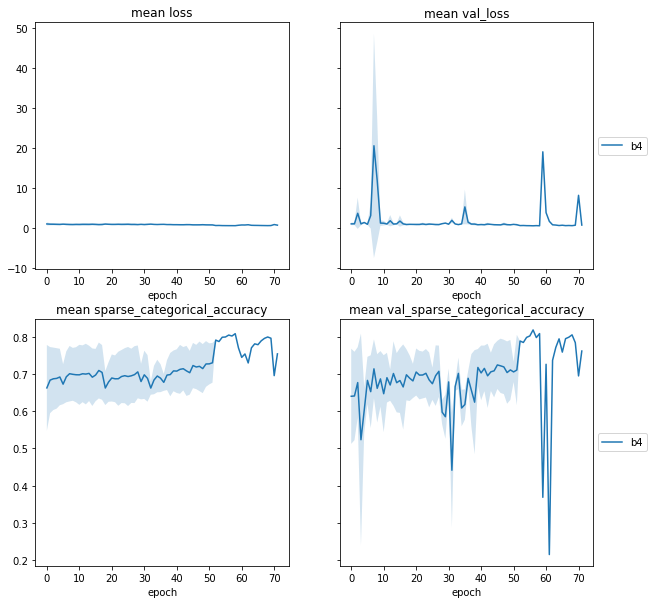

In [60]:
names = ['b4']
plot_pmc_2 = load_csv("h5_finaux/b4")
plot_logs2(plot_pmc_2,names)

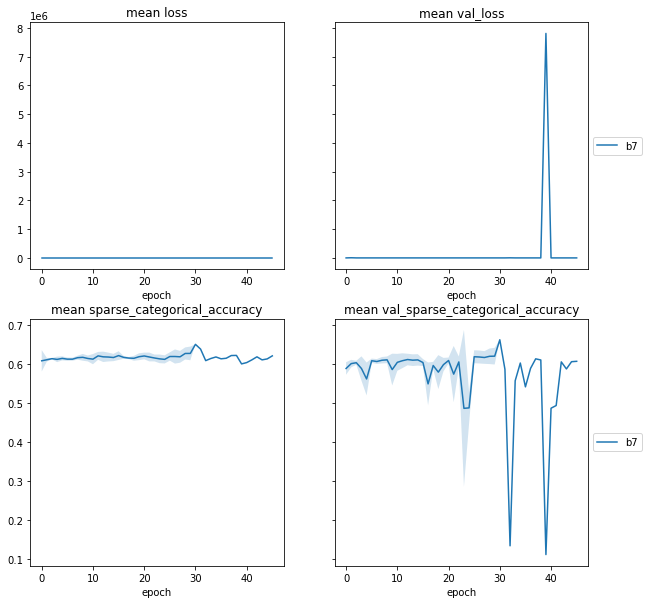

In [61]:
names = ['b7']
plot_pmc_2 = load_csv("h5_finaux/b7")
plot_logs2(plot_pmc_2,names)

# Comparaison plot

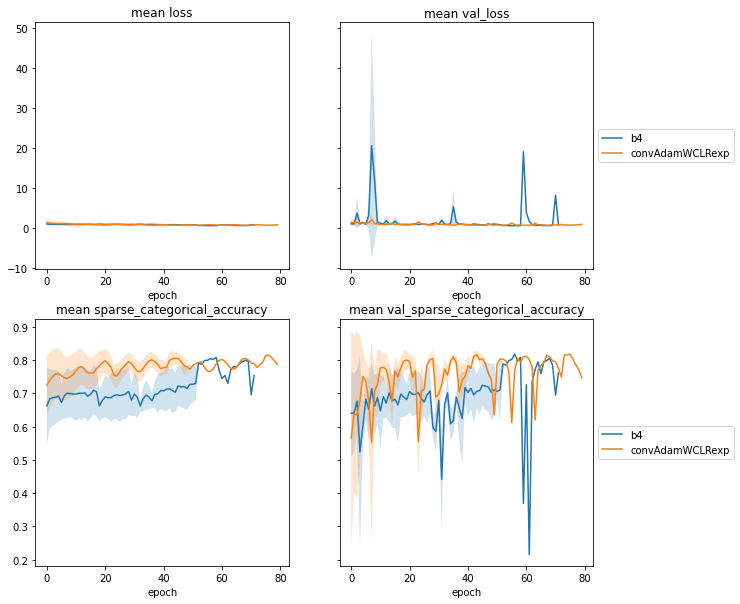

In [62]:
names = ['b4', 'convAdamWCLRexp']
plot_pmc_2 = load_csv2("h5_finaux/b4", "h5_finaux/conv81_9")
plot_logs2(plot_pmc_2,names)